In [1]:
import json
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr


In [2]:
def calc_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(len(sorted_data)) / (len(sorted_data))
    median = np.median(sorted_data)
    sorted_data = np.append(sorted_data, np.ones(1))
    cdf = np.append(cdf, np.ones(1))
    auc = np.trapezoid(cdf, sorted_data)
    
    return sorted_data, cdf, median, auc


In [3]:
path_LSTM = Path("results/run_LSTM")
path_SHM = Path("results/run_SHM")
path_Tower = Path("results/run_Tower")

paths_results = [path_LSTM, path_SHM, path_Tower]

### Performance CDF

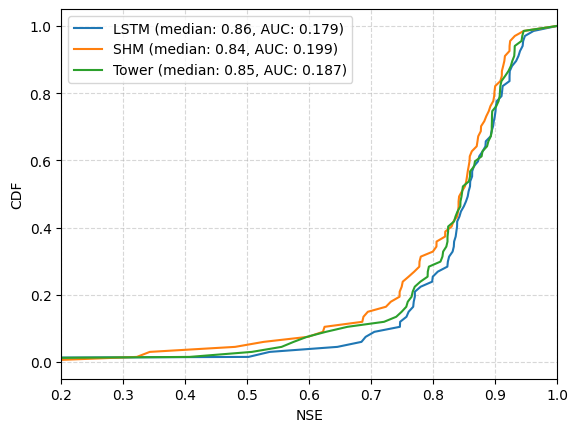

In [4]:
fig, ax = plt.subplots()
for path in paths_results:
    metrics = json.load(open(path / "metrics.json"))
    nse = [metric["nse"] for metric in metrics.values()]
    sorted_data, cdf, median, auc = calc_cdf(nse)
    name = str(path.name).split("_")[-1]
    ax.plot(sorted_data, cdf, label=f"{name} (median: {median:.2f}, AUC: {auc:.3f})")
ax.set_xlim(0.2, 1)
ax.set_xlabel("NSE")
ax.set_ylabel("CDF")
ax.grid(ls="--", alpha=0.5)
plt.legend()
plt.show()

### Entropy Violin Plots

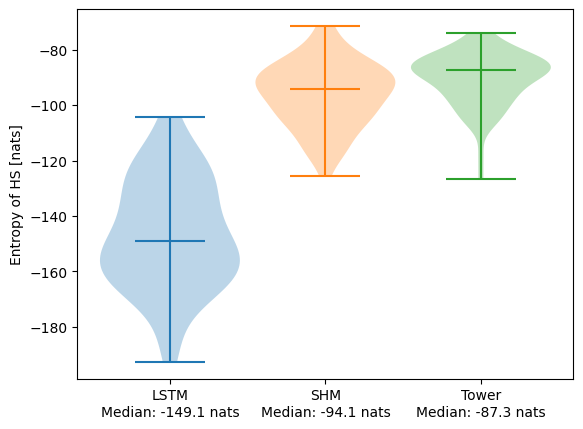

In [5]:
fig, ax = plt.subplots()
names = []
for path in paths_results:
    metrics = json.load(open(path / "metrics.json"))
    h_hs = [metric["h_hs"] for metric in metrics.values()]
    names.append(str(path.name).split("_")[-1] + f"\nMedian: {np.median(h_hs):.1f} nats")
    ax.violinplot(h_hs, positions=[len(names)], widths=0.9, showmedians=True)
ax.set_xticks(range(1, len(names) + 1))
ax.set_xticklabels(names)
ax.set_ylabel("Entropy of HS [nats]")
plt.show()

### Analysis with ERA5

In [6]:
analysis_period = pd.date_range(start="2004-11-01", end="2005-04-01", freq="D")

results_LSTM = xr.open_dataset(path_LSTM / "results.nc").sel(basin="5003", last_n=-1, date=analysis_period)
results_SHM = xr.open_dataset(path_SHM / "results.nc").sel(basin="5003", last_n=-1, date=analysis_period)
results_Tower = xr.open_dataset(path_Tower / "results.nc").sel(basin="5003", last_n=-1, date=analysis_period)

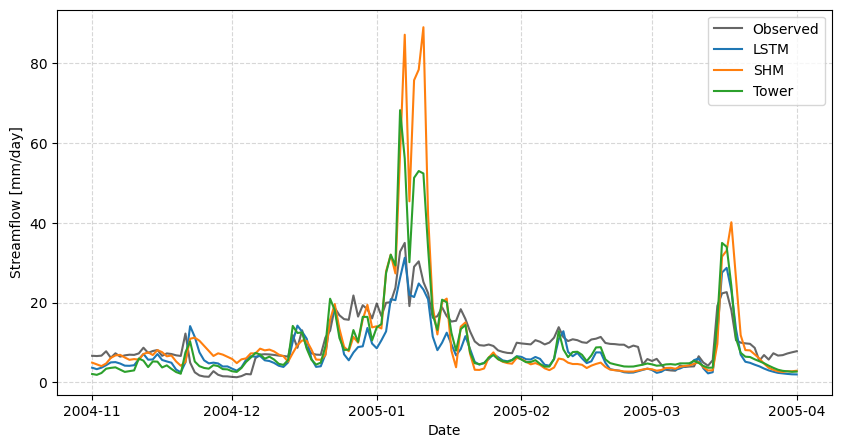

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(analysis_period, results_LSTM.y_obs.values.flatten(), color="k", label="Observed", alpha=0.6)
ax.plot(analysis_period, results_LSTM.y_hat.values.flatten(), label="LSTM")
ax.plot(analysis_period, results_SHM.y_hat.values.flatten(), label="SHM")
ax.plot(analysis_period, results_Tower.y_hat.values.flatten(), label="Tower")
ax.set_xlabel("Date")
ax.set_ylabel("Streamflow [mm/day]")
ax.legend()
ax.grid(ls="--", alpha=0.5)
plt.show()

In [14]:
path_era5 = Path("../hybrid_models-git/data/ERA5/gb_era5.pkl")

with open(path_era5, "rb") as f:
    era5_data = pickle.load(f)
    
swvl3 = era5_data["5003"].loc[analysis_period]["swvl3"]

C:\Users\ac140439\AppData\Local\Temp\ipykernel_6580\1867854522.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  era5_data = pickle.load(f)


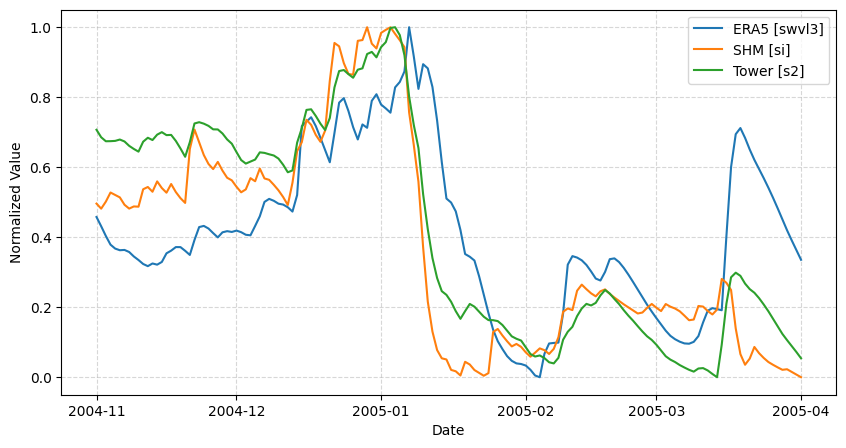

In [15]:
def normalize(data):
    return (data - data.min()) / (data.max() - data.min())

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(analysis_period, normalize(swvl3.values.flatten()), label="ERA5 [swvl3]")
ax.plot(analysis_period, normalize(results_SHM["internal_si"].values.flatten()), label="SHM [si]")
ax.plot(analysis_period, normalize(results_Tower["internal_s2"].values.flatten()), label="Tower [s2]")
ax.set_xlabel("Date")
ax.set_ylabel("Normalized Value")
ax.grid(ls="--", alpha=0.5)
ax.legend()
plt.show()